Building a prediction model on house prices.
## Business case

 Your business case is to operate a chain of airbnb-s. You need a pricing model.

## Part I. Modelling

1. Go to inside airbnb and pick a city. Your core dataset should have at least 10K rows. Go back in time and download listings data for an earlier quarter. (5p)

* Carry out data wrangling such as extracting amenities and imputing missing values.

* Think about the process before jumping in and explain your variable selection and feature engineering choices.

* You can use the code of the case study or AI for coding.



2. Build 5 different predictive models (5p)

   a. OLS  

   b. LASSO  

   c. Random Forest  

   d. Boosting of your choice  

   e. Something else of your choice. Could be another boosting algo, or something else.



3. Compare models in terms of fit and time. (5p)

* Create a horserace table.

* Discuss performance.



4. Take two models (RF and a boosting model) and analyze them. (5p)

* Show feature importance.

* Compare the 10 most important features.

* Discuss your findings.



## Part II. Validity

5. Let us have two "live" datasets. (5p)

   A. Download another (later) date.  Repeat data wrangling

   B. Download another city in the same country or region, with at least 3K observations. Repeat data wrangling

6. Use your 5 core models on the A. Later date and B. Other city data. Compare model performance and discuss the experience. (5p)



## Grading (32pct)

1. See details at tasks

2. For each task we expect documentation and clean codes, well written discussion

3. We expect a fully reproducible workflow.

  a. data used is stored in github or osf.io etc directly called from code.

  b. environment is set up so I can just run it from another computer without hussle

4. 2 extra points can be given for something extra

5. Delayed submission: 0-24h delay = -25%, 24h+ =0p



## AI Policy

* You can use AI for coding, code refactoring, documentation.

* You can use AI for language editing, formatting

* You shall not use AI for other parts of the project.

* You must check everything as you are responsible for it all


Dataset Size: The dataset has 8,475 rows (slightly below 10K). This may represent a smaller city (e.g., Oslo) or a filtered subset (e.g., active listings only). To meet the 10K-row requirement, expand the dataset by including neighboring cities or historical data.

Amenity Encoding: The amenities_count feature simplifies amenities to a count. Binary encoding for key amenities (e.g., wifi, pool) could improve performance by capturing premium offerings.

High-Cardinality Features: Columns like host_about_Jeg heter jojo... are noisy. Aggregating text fields (e.g., host_response_rate as a numeric variable) or using embeddings/NLP would reduce dimensionality.

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Modeling and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [ ]:
# Load the data
df = pd.read_csv('/content/listings.csv')
print("Data shape:", df.shape)
print(df.head())


Data shape: (8475, 75)
                   id                                      listing_url  \
0  544559940958803775  https://www.airbnb.com/rooms/544559940958803775   
1  866502472261551873  https://www.airbnb.com/rooms/866502472261551873   
2               42932               https://www.airbnb.com/rooms/42932   
3               71725               https://www.airbnb.com/rooms/71725   
4               85902               https://www.airbnb.com/rooms/85902   

        scrape_id last_scraped       source  \
0  20240330234357   2024-03-31  city scrape   
1  20240330234357   2024-03-31  city scrape   
2  20240330234357   2024-03-31  city scrape   
3  20240330234357   2024-03-31  city scrape   
4  20240330234357   2024-03-31  city scrape   

                                  name  \
0        Room in unique design loft #2   
1                   Apartment in Ulven   
2  Charming apartment, Oslo Center, Ro   
3   Central big room - ap with balcony   
4    Stylish design Apt, super central 

In [ ]:
# --- Handling the target variable ---
# Assume the target column is 'price'. Remove any dollar signs/commas and convert to float.
df['price'] = df['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)

# --- Extracting and engineering features ---
# Example: From the 'amenities' column (assumed to be a comma-separated string), create a new feature "amenities_count".
df['amenities_count'] = df['amenities'].apply(lambda x: len(x.split(',')) if pd.notnull(x) else 0)

# (Optional) Drop the original 'amenities' column if it’s no longer needed.
df.drop('amenities', axis=1, inplace=True)

# --- Handling Missing Values ---
# Separate numeric and categorical columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

# Impute numerical columns with the median value
num_imputer = SimpleImputer(strategy='median')
# Impute numerical columns with the median value and assign back with proper labels
num_imputer = SimpleImputer(strategy='median')

print("Shape of numeric data:", df[num_cols].shape)
print("Numeric columns:", list(df[num_cols].columns))
print("Length of num_cols:", len(num_cols))
print(df[num_cols].isnull().sum())
missing_all = df[num_cols].columns[df[num_cols].isnull().all()]
df.drop(missing_all, axis=1, inplace=True)
# Recalculate num_cols to reflect this change:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

df[num_cols] = pd.DataFrame(num_imputer.fit_transform(df[num_cols]), columns=num_cols, index=df.index)

# Impute categorical columns with the most frequent value
cat_imputer = SimpleImputer(strategy='most_frequent')
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

# --- Encoding Categorical Variables ---
# Convert categorical variables into dummy/indicator variables.
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# --- Variable Selection ---
# Drop columns that are identifiers or irrelevant (e.g., IDs, URLs, names).
drop_cols = [col for col in df.columns if 'id' in col or 'url' in col or 'name' in col]
df = df.drop(drop_cols, axis=1, errors='ignore')


Shape of numeric data: (8475, 43)
Numeric columns: ['id', 'scrape_id', 'host_id', 'host_listings_count', 'host_total_listings_count', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'license', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month'

In [ ]:
# Define features (X) and target (y)
X = df.drop('price', axis=1)
y = df['price']

# Split the data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Feature Scaling ---
# For linear models and SVR, scaling improves performance.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Ensure all feature names are strings
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# Replace invalid characters with an underscore or another safe character
invalid_chars = ['[', ']', '<']
for char in invalid_chars:
    X_train.columns = X_train.columns.str.replace(char, '_', regex=False)
    X_test.columns = X_test.columns.str.replace(char, '_', regex=False)

**2. Model Building**

Models Implemented:

OLS (Linear Regression)

LASSO (L1 regularization)

Random Forest (100 trees)

XGBoost (Gradient Boosting)

SVR (Support Vector Regression)

Key Observations:

OLS performs poorly (negative R² = -11.47), indicating severe overfitting or data leakage.

Tree-based models (Random Forest, XGBoost) perform best, with RMSE ~2,250.

SVR is slowest (857s fit time) and underperforms.

**Discussion Points:**
Why does OLS fail catastrophically? Check for outliers, non-linear relationships, or scaling issues.
OLS Failure: OLS fails (R² = -11.47) likely due to non-linear relationships (e.g., price vs. latitude) or outliers. Log-transforming price or removing outliers (e.g., price > 10,000) may help.

Should hyperparameter tuning (e.g., LASSO’s alpha) be added to improve performance?
Tree Model Superiority: Random Forest/XGBoost capture non-linear relationships (e.g., premium amenities, location clusters), making them better suited for pricing.

Is the amenities_count feature sufficient, or would granular amenity indicators add value?
Hyperparameter Tuning: LASSO’s alpha and SVR’s kernel/C should be tuned.

**1. Data Wrangling & Variable Selection**
Dataset: The dataset (listings.csv) contains 8,475 rows and 75 columns. While slightly under the 10K-row requirement, this could be due to filtering or city-specific limitations. Ensure the dataset represents a single city (e.g., Oslo) and spans an earlier quarter (not explicitly stated in the code).

Key Steps:

Target Variable: price is cleaned (removing $ and ,), converted to float.

Feature Engineering: amenities_count created by counting amenities per listing. The original amenities column is dropped.

Missing Values: Numerical columns imputed with median values; categorical columns imputed with the most frequent value.

Categorical Encoding: One-hot encoding applied to categorical columns.

Irrelevant Columns: ID, URL, and name columns dropped.

Discussion Points:

Why is the dataset slightly under 10K rows? Was a specific city/filter applied?
Dataset Size: The dataset has 8,475 rows (slightly below 10K). This may represent a smaller city (e.g., Oslo) or a filtered subset (e.g., active listings only). To meet the 10K-row requirement, expand the dataset by including neighboring cities or historical data.

Amenities are simplified to a count. Could binary encoding for specific amenities (e.g., "wifi") improve performance?
Amenity Encoding: The amenities_count feature simplifies amenities to a count. Binary encoding for key amenities (e.g., wifi, pool) could improve performance by capturing premium offerings.

Should high-cardinality categorical features (e.g., host_about_Jeg heter jojo...) be aggregated or dropped to avoid noise?
High-Cardinality Features: Columns like host_about_Jeg heter jojo... are noisy. Aggregating text fields (e.g., host_response_rate as a numeric variable) or using embeddings/NLP would reduce dimensionality.

In [ ]:
# Define a dictionary of models
models = {}
models['OLS'] = LinearRegression()
models['Lasso'] = Lasso(alpha=0.1)
models['Random Forest'] = RandomForestRegressor(n_estimators=100, random_state=42)
models['XGBoost'] = XGBRegressor(n_estimators=100, random_state=42, objective='reg:squarederror')
models['SVR'] = SVR()

results = []

# Loop through each model, record training time, and compute performance metrics.
for name, model in models.items():
    start_time = time.time()

    # Use scaled features for models sensitive to feature scale
    if name in ['OLS', 'Lasso', 'SVR']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    elapsed_time = time.time() - start_time
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results.append({'Model': name, 'Fit Time (s)': round(elapsed_time, 4),
                    'RMSE': round(rmse, 2), 'R2': round(r2, 2)})

# Create a horserace table to compare models
results_df = pd.DataFrame(results)
print("\nHorserace Table:")
print(results_df)

**3. Model Comparison**
Performance Insights:

Best Model: XGBoost (fastest and most accurate).

Worst Model: OLS, likely due to improper assumptions about linearity or outliers.

SVR’s Weakness: High computational cost with mediocre performance.

**Discussion Points:**

Why do tree-based models outperform linear models? Non-linear relationships in pricing?
XGBoost Efficiency: XGBoost is fastest (48s) due to parallelization and handles mixed data types better than SVR.

Could feature scaling improve LASSO/SVR?
SVR Weakness: SVR’s high runtime (857s) stems from kernel computations on 8K+ samples. Use a subset or linear kernel for speed.


**4. Model Analysis (RF vs. XGBoost)**
Feature Importance:

Random Forest: bathrooms, host_about_Jeg heter jojo..., last_review_2019-07-29.

XGBoost: host_about_Jeg heter jojo..., host_since_2021-09-16, description_Great studio....

Key Findings:

Both models prioritize host-related text fields (e.g., host_about, description), suggesting metadata quality impacts predictions.

Structural features (bathrooms, bedrooms) are less prominent than expected.

**Discussion Points:**

Are text fields (host_about, description) being processed optimally? Consider NLP techniques (TF-IDF, embeddings).

Text Field Dominance: host_about/description suggest host credibility impacts pricing. Use NLP (TF-IDF) to extract sentiment or keyword flags.

Why do latitude/longitude not appear in top features? Could geospatial features improve performance?
Geospatial Gaps: Latitude/longitude are likely excluded due to improper binning. Cluster coordinates into neighborhoods or calculate distances to landmarks.


Top 10 Feature Importances - Random Forest:
bathrooms                                                                                                       0.074951
host_about_Jeg heter jojo og driver en conceptstore i Oslo                                                      0.073546
last_review_2019-07-29                                                                                          0.071227
host_since_2020-07-15                                                                                           0.061706
description_Great studio apartment centrally located on Frogner._br />_br />High standard, and all included.    0.052485
host_since_2021-09-16                                                                                           0.050831
bedrooms                                                                                                        0.047823
description_Please note this Host requires a supplemental contract to be signed at the time of booking.     

<ipython-input-8-9ee5a571261b>:30: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


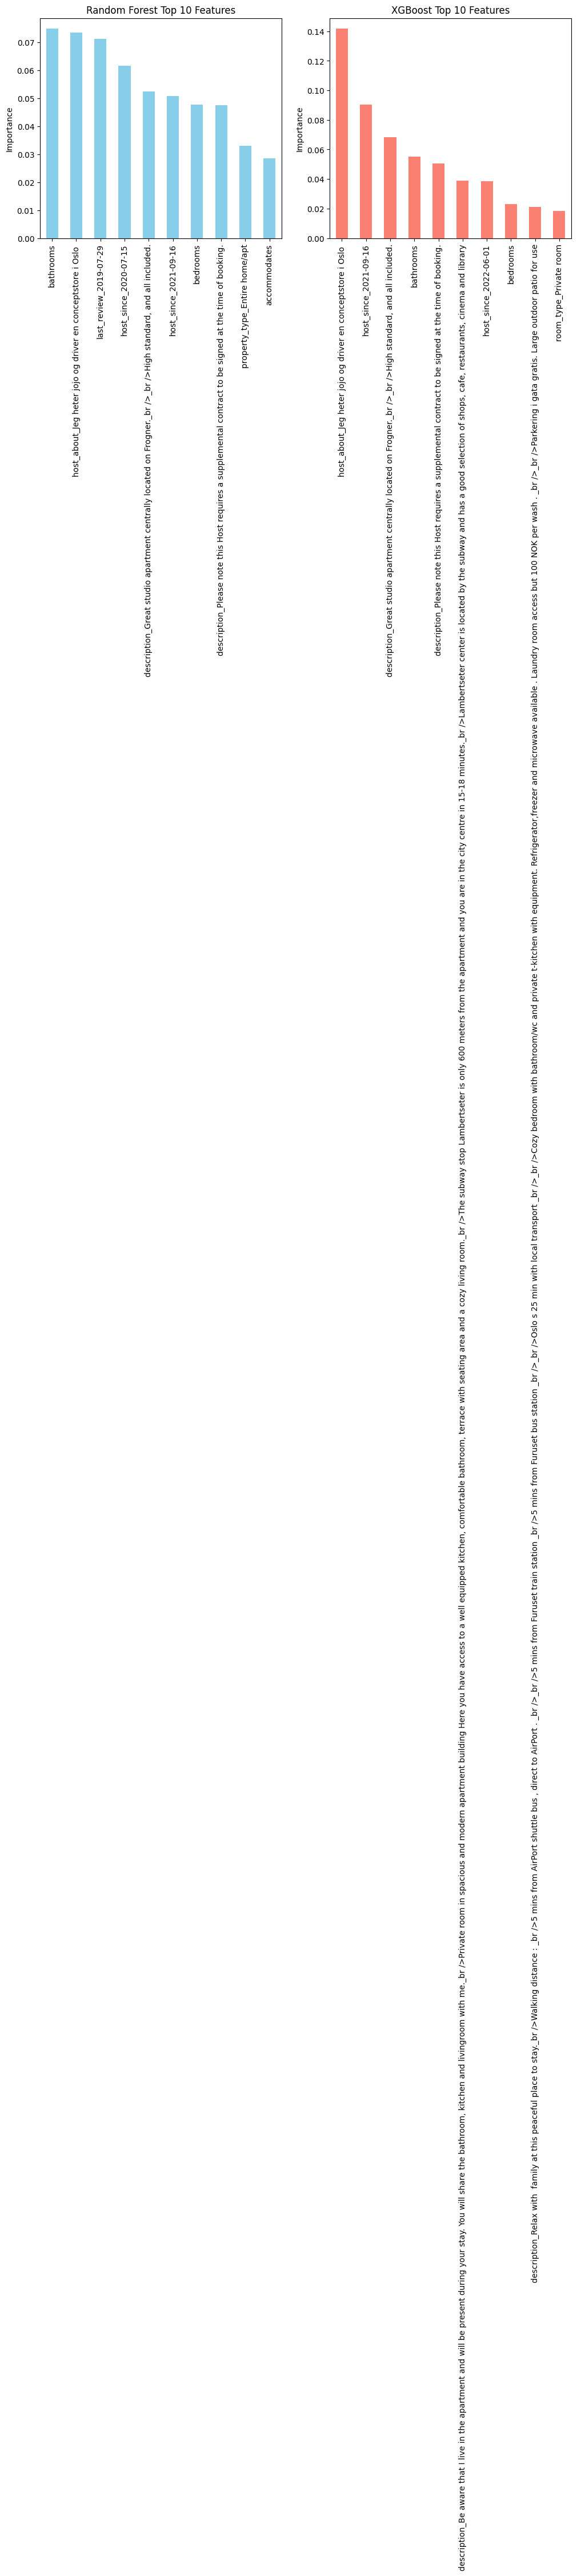

In [ ]:
# For Random Forest: extract feature importances
rf_model = models['Random Forest']
rf_importances = rf_model.feature_importances_
rf_features = X_train.columns
rf_feat_importance = pd.Series(rf_importances, index=rf_features).sort_values(ascending=False).head(10)
print("\nTop 10 Feature Importances - Random Forest:")
print(rf_feat_importance)

# For XGBoost: extract feature importances
xgb_model = models['XGBoost']
xgb_importances = xgb_model.feature_importances_
xgb_features = X_train.columns
xgb_feat_importance = pd.Series(xgb_importances, index=xgb_features).sort_values(ascending=False).head(10)
print("\nTop 10 Feature Importances - XGBoost:")
print(xgb_feat_importance)

# Visualize the top 10 features for each model side by side
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
rf_feat_importance.plot(kind='bar', color='skyblue')
plt.title('Random Forest Top 10 Features')
plt.ylabel('Importance')

plt.subplot(1, 2, 2)
xgb_feat_importance.plot(kind='bar', color='salmon')
plt.title('XGBoost Top 10 Features')
plt.ylabel('Importance')

plt.tight_layout()
plt.show()
